In [48]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D

eps = np.finfo(float).eps

def getRGB(path):
    im_BGR = cv2.imread(path,cv2.COLOR_GRAY2RGB)
    im = cv2.cvtColor(im_BGR,cv2.COLOR_BGR2RGB)
    return im

def showThreeImg(img1,img2,img3,img_name1 = None,img_name2 = None,img_name3 = None):
    plt.figure(figsize=(18,6))
    ax1 = plt.subplot(131)
    ax1.set_title(img_name1)
    ax1.imshow(img1  , cmap = "gray")
    ax2 = plt.subplot(132)
    ax2.imshow(img2, cmap = "gray")
    ax2.set_title(img_name2)
    ax3 = plt.subplot(133)
    ax3.imshow(img3,cmap = "gray")
    ax3.set_title(img_name3)
    plt.show()

# 图像复原与重建初步

梳理所学重点知识

## 引言

前面所接触的图像增强是一个，已知原图像，经处理后，得到增强图像的一个过程，而这一章将要深入的图像复原（重建），则是希望从（被污染）过的图像，经处理后，得到原图像的过程，是以**预先确定的目标**来改善图像。图像复原试图利用退化现象的某种**先验知识**来复原被退化的图像。因而，复原技术时面向退化模型的，并且采用相反的过程进行处理，以便恢复出原图像。虽然图像增强和图像复原两者在覆盖的领域和使用的技术栈有所重叠，其中还是有几点区别我们还是要提起注意的。

- 形象化的描述

    图像增强主要是一个主观的过程，而图像复原大部分是一个客观的过程。

- 已知与未知的区别

    图像增强已知原始图像与变换（卷积核或者其频率域的谱），对于增强效果是未知且非预先确定的（只有一个大概方向，比如模糊还是锐化），而图像复原则已知污染图像，且对原始图像是预先确定的（测试条件下甚至是有标准比对的原始图像，是已知的），对于复原变换（污染变换的逆）常常是未知的，这就要求我们在做图像处理时常常需要“估计”我们的复原变换。
    
- 期望与探索的区别
    
    由于两者已知和未知上的差距，这就导致图像复原通常会涉及设立一个**最佳准则**来产生期望结果的最佳估计。相比之下，图像增强技术基本上是一个**探索性过程**，即根据人类视觉系统的生理特点来设计改善图像的方法。
    

## 图像退化/复原过程模型

退化过程（污染过程）的描述：建模为一个退化函数和一个加性噪声项，对于输入图像（原图像）$f(x,y)$进行处理，产生一副退化后的图像$g(x,y)$，图像复原目的就是已知$g(x,y)$的前提下，希望得到原图像的一个估计，这个估计越接近原始输入图像越好。空间域中的退化图像可由下式给出：

$$g(x,y) = h(x,y) \star f(x,y) + \eta(x,y)$$

上式中$h(x,y)$是退化函数的空间表示，由第四章内容，我们可以将上式的模型写成等价的频率域表示：

$$g(u,v) = H(u,v) F(u,v) + N(u,v)$$

这两个式子是本章后面大部分复原内容的基础。

## 噪声模型

### 噪声的空间和频率特性

一些重要概念：

当噪声的傅里叶谱是常量时，噪声通常成为**白噪声**，这个术语是从白光的物理特性派生出来的，它以相等的比例包含可见光谱中的几乎所有频率。

除了空间周期噪声之外，本章假设其他噪声与空间坐标无关，并且噪声与图像本身不想管（即像素值与噪声成分的值之间不相关）。虽然这些假设至少在某些应用中（例如X射线和医学成像的有限量子成像就是一个很好的例子）是无效的，但处理空间相关和相关性噪声的复杂性超出了我们讨论的范围。

### 一些重要的噪声概率密度函数

概率论回顾

1. 高斯（正态）噪声

    其PDF由下式给出：

    $$p(z) = \dfrac{1}{\sqrt{2 \pi} \sigma} e^{ \frac{ {(z- \overline{z})}^2 }{2 \sigma^2} }$$

    $\overline{z}$表示$z$的均值，$\sigma$表示$z$的标准差。

2. 瑞利噪声

    其PDF由下式给出：

    $$ p(z)=\left \{
    \begin{aligned}
    \frac{2}{b}(z-a)e^{ \frac{-{(z-a)}^2}{b} }  & , &   z  \ge a \\
    0 & , & z < a
    \end{aligned}
    \right. $$
    
    概率密度的均值与方差的给出：$\overline{z} = a + \sqrt{ \pi b / 4}$，$\sigma ^2 = \dfrac{b(4-\pi)}{4}$

3. 爱尔兰（伽马）噪声

    其PDF由下式给出：

    $$ p(z)=\left \{
    \begin{aligned}
    \dfrac{a^bz^{b-1}}{(b-1)!}e^{ -az}  & , &   z  \ge a \\
    0 & , & z < a
    \end{aligned}
    \right. $$
    
    概率密度的均值与方差的给出：$\overline{z} = \dfrac{b}{a}$ ，$\sigma ^2 = \dfrac{b}{a^2}$
    
4. 指数噪声

    其PDF由下式给出：
    
    $$ p(z)=\left \{
    \begin{aligned}
    ae^{ -az}  & , &   z  \ge a \\
    0 & , & z < a
    \end{aligned}
    \right. $$
    
    可以看作是$b=1$时爱尔兰PDF的特殊情况。概率密度的均值和方差是：$\overline{z} = \dfrac{1}{a}$，$\sigma^2 = \dfrac{1}{a^2}$
    
5. 均匀噪声

    其PDF由下式给出：
    
    $$ p(z)=\left \{
    \begin{aligned}
    \dfrac{1}{b-a}  & , &   a \le z \le b \\
    0 & , & 其他
    \end{aligned}
    \right. $$
    
    概率密度的均值与方差的给出：$\overline{z} = \dfrac{a+b}{2}$，$\sigma^2 = \dfrac{{(b-a)}^2}{12}$
    
6. 脉冲（椒盐）噪声

    其PDF由下式给出：
    
    $$ p(z)=\left \{
    \begin{aligned}
    P_a  & , &   z = a \\
    P_b & , &  z = b \\
    1-P_a-P_b & , & 其他
    \end{aligned}
    \right. $$

In [29]:
# 编写 添加噪声函数 并显示噪声情况

def getGaussianNoise(loc,scale,size = None):
    return np.random.normal(loc,scale,size)

def getRayleighNoise(scale,size = None):
    # b = 2 scle^2 这里统一根据使用 scale
    return np.random.rayleigh(scale,size)

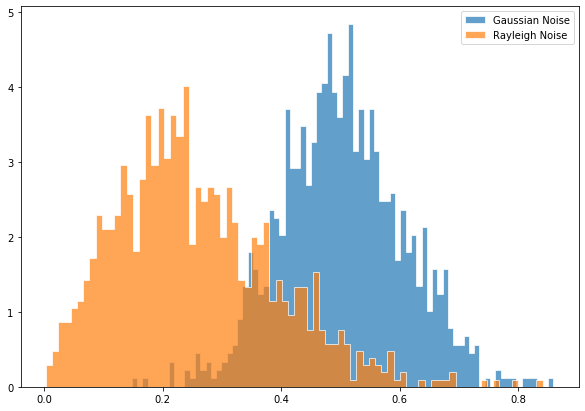

In [30]:
# 测试函数，展示高斯和瑞利的分布直方图

mu = 0.5
sigma = 0.1
sigma2 = 0.2

gnoise = getGaussianNoise(mu,sigma,1000)
rnoise = getRayleighNoise(sigma2,1000)

plt.figure(figsize=(10,7))
ax1 = plt.subplot(111)
ax1.hist(gnoise,80,density = True,histtype = 'stepfilled',edgecolor = "white",label = "Gaussian Noise",alpha = 0.7)
ax1.hist(rnoise,80,density = True,histtype = 'stepfilled',edgecolor = "white", label = "Rayleigh Noise" , alpha = 0.7)
ax1.legend()
plt.show()

In [44]:
# 给图像加噪声
def getGaussianNoiseImg(input_img, loc, scale,rate = 1):
    """
    getGaussianNoiseImg 获得被高斯白噪声污染的图像
    
    :param input_img: 输入原始图像
    :param loc: 高斯分布均值
    :param scale: 高斯分布标准差
    :return: 加噪的图像
    """
    float_img = np.array(input_img/255, dtype = np.float64)
    noise = np.random.normal(loc,scale,float_img.shape)
    output_img = float_img+noise*rate
    output_img = np.clip(output_img,0,1.0)
    output_img = np.uint8(output_img*255)
    return output_img
    
    
    
def getRayleighNoiseImg(input_img, scale,rate = 1):
    """
    getRayleighNoiseImg 获得被瑞利白噪声污染的图像
    
    :param input_img: 输入原始图像
    :param scale: 瑞利分布的scale 与b相关 a为0（没找到调整方法）
    :return: 加噪的图像
    """
    float_img = np.array(input_img/255, dtype = np.float64)
    noise = np.random.rayleigh(scale,float_img.shape)
    output_img = float_img+noise*rate
    output_img = np.clip(output_img,0,1.0)
    output_img = np.uint8(output_img*255)
    return output_img

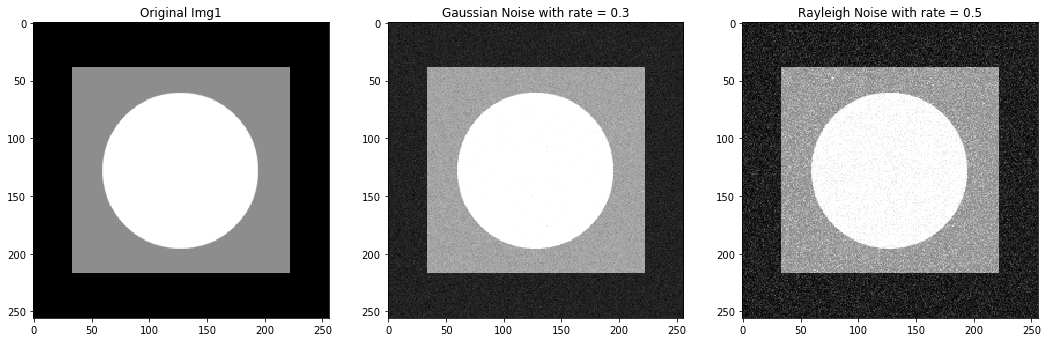

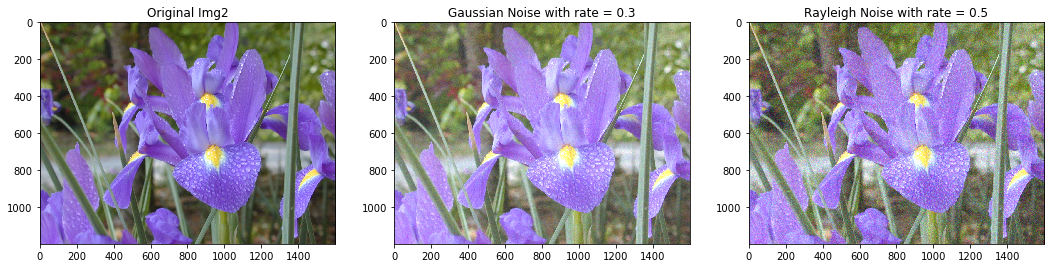

In [50]:
mu = 0.5
sigma1 = 0.1
sigma2 = 0.2


img1 = cv2.imread('./5_1Photo/Fig0503.tif',0)
gnoise_img1 = getGaussianNoiseImg(img1,mu,sigma1,0.3)
rnoise_img1 = getRayleighNoiseImg(img1,sigma2,0.5)

img2 = getRGB('./5_1Photo/4.tif')
gnoise_img2 = getGaussianNoiseImg(img2,mu,sigma1,0.3)
rnoise_img2 = getRayleighNoiseImg(img2,sigma2,0.5)

showThreeImg(img1,gnoise_img1,rnoise_img1,"Original Img1","Gaussian Noise with rate = 0.3","Rayleigh Noise with rate = 0.5")
showThreeImg(img2,gnoise_img2,rnoise_img2,"Original Img2","Gaussian Noise with rate = 0.3","Rayleigh Noise with rate = 0.5")